In [1]:
import utils.data_import as data_import
import utils.ml_utils as ml_utils

import torch, torchtext
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext import data, vocab

import os, sys
import pdb
import pandas as pd

/r/ge.unx.sas.com/vol/vol620/u62/ivoliv/.conda/envs/ONE/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [2]:
import settings

if settings.ORIG_DATA == 0:
    train_file = 'training.txt'
    train, valid = data_import.normalize_and_split(org_data_path, train_file, test_size=settings.test_size)
elif settings.ORIG_DATA == 1:
    train_file = settings.imdb_file
    train, valid = data_import.import_imbd(train_file, to=10000, test_size=settings.test_size)
elif settings.ORIG_DATA == 2:
    df = data_import.import_wikitext(window_size=settings.window_size, lines=settings.lines)
    train, valid = data_import.create_splits(df, test_size=settings.test_size)

text length: 213886


In [3]:
cuda = torch.cuda.is_available()
if cuda:
    print('Cuda is available!')
    print('Device:', torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print('No cuda.')
    
import matplotlib.pyplot as plt
%matplotlib inline

Cuda is available!
Device: Tesla V100-SXM2-16GB


In [4]:
valid.head()

,tag,statement,tag_id
234,–,"which they must shed in order to grow , in a p...",83
42,pair,"the American lobster , H. americanus . It may ...",32
303,claw,rounded <unk> used for crushing prey ; the oth...,143
155,pots,"<unk> , with a body length up to 60 centimetre...",70
342,This,", and the right is the cutter . The <unk> is g...",111


In [5]:
data_import.create_split_files('.', train, valid)

Writing files to ./data
Train and validation files written to disk.
Sizes: (320, 3) (80, 3)


In [6]:
data_path = './data'

In [7]:
TEXT = data.Field(sequential=True, lower=False)
LABEL = data.Field(sequential=False, use_vocab=False)
#SENTIMENT = data.Field(sequential=False, use_vocab=False)

In [8]:
datafields = [('tag', None),
              ('statement', TEXT),
              ('tag_id', LABEL)]

train, test = data.TabularDataset.splits(
    path=data_path,
    train='train.csv', validation='valid.csv',
    format='csv',
    skip_header=True,
    fields=datafields)

In [9]:
#TEXT.build_vocab(train, test, train_imdb, test_imdb, vectors='glove.6B.'+str(settings.emb_dim)+'d')
TEXT.build_vocab(train, test, vectors='glove.6B.'+str(settings.emb_dim)+'d')
#TEXT.build_vocab(train, test)
LABEL.build_vocab(train, test)
#SENTIMENT.build_vocab(train_imdb, test_imdb)

In [10]:
n_vocab = len(dict(TEXT.vocab.freqs).keys())
print('Vocab size:', n_vocab)
n_classes = len(dict(LABEL.vocab.freqs).keys())
print('Number of classes:', n_classes)
#n_sent = len(dict(SENTIMENT.vocab.freqs).keys())
#print('Number of sentiments:', n_sent)
#print((TEXT.vocab.itos))

Vocab size: 197
Number of classes: 170


In [11]:
print('len(trn):', len(train))
print('len(test):', len(test))
print()
print(TEXT.vocab.freqs.most_common(20))
print()
print(TEXT.vocab.itos[:10])
#print(vars(train[0]))
print()
print(LABEL.vocab.freqs.most_common(20))
#print(LABEL.vocab.stoi)
#print(SENTIMENT.vocab.stoi)

len(trn): 320
len(test): 80

[(',', 1815), ('the', 1362), ('.', 1042), ('is', 946), ('<unk>', 863), ('a', 842), ('and', 689), ('in', 575), ('to', 540), ('of', 509), ('–', 490), (')', 481), ('(', 476), ('"', 420), ('The', 398), ('lobster', 351), ('lobsters', 350), ('for', 350), ('=', 285), ('@.@', 280)]

['<unk>', '<pad>', ',', 'the', '.', 'is', 'a', 'and', 'in', 'to']

[('10', 26), ('7', 19), ('1', 16), ('3', 14), ('60', 12), ('15', 12), ('24', 10), ('6', 8), ('22', 8), ('17', 7), ('23', 7), ('83', 7), ('20', 7), ('41', 6), ('123', 6), ('9', 5), ('36', 5), ('54', 5), ('55', 4), ('94', 4)]


In [12]:
#print(TEXT.vocab.vectors.shape)
vocab_size = len(TEXT.vocab)
#TEXT.vocab.vectors[TEXT.vocab.stoi['the']]

In [13]:
#trn, vld = train.split(0.7)
trn = train
vld = test
print('len(trn):', len(trn))
print('len(vld):', len(vld))
print('len(test):', len(test))

len(trn): 320
len(vld): 80
len(test): 80


In [14]:
train_iter, val_iter = data.BucketIterator.splits(
    datasets=(trn, vld),
    batch_sizes=(settings.batch_size, settings.batch_size),
    sort_key=lambda x: len(x.statement),
    sort_within_batch=False,
    repeat=False
)

In [15]:
class BatchGenerator:
    def __init__(self, dl, x_field, y_fields):
        self.dl, self.x_field, self.y_fields = dl, x_field, y_fields
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            X = getattr(batch, self.x_field)
            y = getattr(batch, self.y_fields)
            #y = torch.cat([getattr(batch, feat).unsqueeze(1) 
            #               for feat in self.y_fields], dim=1).float()
            if cuda:
                X = X.cuda()
                y = y.cuda()
            yield (X, y)

In [16]:
train_dl = BatchGenerator(train_iter, 'statement', 'tag_id')
valid_dl = BatchGenerator(val_iter, 'statement', 'tag_id')

In [17]:
# Requires padding to be set to 100
class SimpleForward(nn.Module):
    def __init__(self, pretrained_vec, emb_dim=50):
        super().__init__()
        self.embedding = nn.Embedding(len(TEXT.vocab), emb_dim)
        self.embedding.weight.data.copy_(pretrained_vec)
        self.embedding.weight.requires_grad = False
        
        self.linear_layer = nn.Linear(emb_dim*100, 128)
        self.linear_out = nn.Linear(128, n_classes)
        
    def forward(self, seq):
        
        seq = seq.permute(1, 0)
        emb = self.embedding(seq)
        
        long_layer = emb.view(-1, emb_dim*100)
        
        out = F.relu(self.linear_layer(long_layer))
        out = self.linear_out(out)
        
        return F.log_softmax(out, dim=-1)
        

In [18]:
class CNN(nn.Module):
    def __init__(self, pretrained_vec, emb_dim, n_channels_per_filter, filter_sizes):
        super().__init__()
        self.embedding = nn.Embedding(len(TEXT.vocab), emb_dim)
        self.embedding.weight.data.copy_(pretrained_vec)
        self.embedding.weight.requires_grad = False
        
        self.conv_0 = nn.Conv2d(in_channels=1, out_channels=n_channels_per_filter,
                                kernel_size=(filter_sizes[0], emb_dim))
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=n_channels_per_filter,
                                kernel_size=(filter_sizes[1], emb_dim))
        self.conv_2 = nn.Conv2d(in_channels=1, out_channels=n_channels_per_filter,
                                kernel_size=(filter_sizes[2], emb_dim))
        
        self.fc = nn.Linear(len(filter_sizes)*n_channels_per_filter, n_classes)
        
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, seq):
        
        seq = seq.permute(1, 0)
        emb = self.embedding(seq)
        
        #print(seq.shape)
        #print(emb.shape)
        
        emb = emb.unsqueeze(1) # introduce 'channel 1'
        
        #print('emb:', emb.shape)
        
        out0 = F.relu(self.conv_0(emb).squeeze(3))
        out1 = F.relu(self.conv_1(emb).squeeze(3))
        out2 = F.relu(self.conv_2(emb).squeeze(3))
        
        #print('out0:', out0.shape)
        
        pooled_0 = F.max_pool1d(out0, out0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(out1, out1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(out2, out2.shape[2]).squeeze(2)
        
        #print('pooled0:', pooled_0.shape)
        
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim=1))
        
        #print('cat:', cat.shape)
        
        out = self.fc(cat)
        
        return F.log_softmax(out, dim=-1)

In [19]:
class simpleRNN(nn.Module):
    def __init__(self, pretrained_vec, emb_dim, hidden_dim, change_emb=True):
        super().__init__()
        self.embedding = nn.Embedding(len(TEXT.vocab), emb_dim)
        self.embedding.weight.data.copy_(pretrained_vec)
        self.embedding.weight.requires_grad = change_emb
        
        self.rnn = nn.RNN(emb_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, n_classes)
        
    def forward(self, seq):
        # seq dims: [seq len, batch size]
        emb = self.embedding(seq)
        # emb dims: [seq len, batch size, emb dim]
        out, hid = self.rnn(emb)
        # out dims: [seq len, batch size, hidden_dim]
        # hid dims: [1, batch size, hidden_dim]
        # hid.squeeze(0) -> [batch size, hidden_dim]
        out = self.fc(hid.squeeze(0))
        # out dims: [batch size, n_classes]
        sm = F.log_softmax(out, dim=-1)
        # sm dims: [batch size, n_classes]
        
        return sm

In [20]:
class simpleLSTM(nn.Module):
    def __init__(self, emb_dim, hidden_dim, n_layers=1, pretrained_vec=torch.zeros(0),
                 change_emb=True, dropout=0):
        super().__init__()
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(len(TEXT.vocab), emb_dim)
        if len(pretrained_vec) > 0:
            print('Loaded pretrained vectors.')
            self.embedding.weight.data.copy_(pretrained_vec)
        else:
            print('Not loaded pretrained vectors.')
        
        self.embedding.weight.requires_grad = change_emb
        
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers=n_layers,
                            bidirectional=True, dropout=dropout)
        
        self.fc = nn.Linear(2*hidden_dim, n_classes)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, seq):
        #pdb.set_trace()
        # seq dims: [seq len, batch size]
        
        emb = self.embedding(seq)
        # emb dims: [seq len, batch size, emb dim]
        
        out, (hid, cel) = self.lstm(emb)
        
        # out dims: [seq len, batch size, hidden_dim]
        # hid dims: [2*n_layers, batch size, hidden_dim]
        # cel dims: [2*n_layers, batch size, hidden_dim]
        # out[-1,:,:hd] -> [batch size, hidden_dim]  (last time step hidden vector)
        # out[0,:,hd:] <- [batch size, hidden_dim]  (first time step hidden vector)
        # contatenation of last time period, whole batch, forward (first) chunck of hidden units
        #   and the first time period, whole batch, backward (last) chunck of hidden units
        #   (pytorch concatenates hidden units across dim #2 for bidirectional LSTM)
        conc = torch.cat((out[-1,:,:self.hidden_dim], out[0,:,self.hidden_dim:]), dim=1)
        
        conc = self.dropout(conc)
        
        output = self.fc(conc)
        # out dims: [batch size, n_classes]
        sm = F.log_softmax(output, dim=-1)
        # sm dims: [batch size, n_classes]
        
        return sm

In [21]:
class simpleLSTMv2(nn.Module):
    def __init__(self, emb_dim, hidden_dim, n_layers=1, pretrained_vec=torch.zeros(0),
                 change_emb=True, dropout=0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim
        
        self.embedding = nn.Embedding(len(TEXT.vocab), emb_dim)
        if len(pretrained_vec) > 0:
            print('Loaded pretrained vectors.')
            self.embedding.weight.data.copy_(pretrained_vec)
        else:
            print('Not loaded pretrained vectors.')
        
        self.embedding.weight.requires_grad = change_emb
        
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers=n_layers-1,
                            bidirectional=True, dropout=dropout)
        
        self.lstm_final = nn.LSTM(hidden_dim*2, emb_dim, num_layers=1)
        
        self.fc = nn.Linear(emb_dim, n_classes)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, seq):
        #pdb.set_trace()
        # seq dims: [seq len, batch size]
        
        emb = self.embedding(seq)
        # emb dims: [seq len, batch size, emb dim]
        
        out, (hid, cel) = self.lstm(emb)
        
        # out dims: [2*seq len, batch size, hidden_dim]       ('2*' comes from bidirectional)
        # hid dims: [2*n_layers-1, batch size, hidden_dim]   
        # cel dims: [2*n_layers-1, batch size, hidden_dim]
        
        out2, (hid2, cel2) = self.lstm_final(out)
        
        # out2 dims: [seq len, batch size, emb_dim]
        # hid2 dims: [2, batch size, emb_dim]
        # cel2 dims: [2, batch size, emb_dim]
        
        # out2[-1,:,:hd] -> [batch size, emb_dim]  (last time step hidden vector)
        # out2[0,:,hd:] <- [batch size, emb_dim]  (first time step hidden vector)
        # contatenation of last time period, whole batch, forward (first) chunck of hidden units
        #   and the first time period, whole batch, backward (last) chunck of hidden units
        #   (pytorch concatenates hidden units across dim #2 for bidirectional LSTM)
        #conc = torch.cat((out2[-1,:,:self.emb_dim], out2[0,:,self.emb_dim:]), dim=1)
        conc = hid2.squeeze(0)
        
        conc = self.dropout(conc)
        
        output = self.fc(conc)
        # out dims: [batch size, n_classes]
        sm = F.log_softmax(output, dim=-1)
        # sm dims: [batch size, n_classes]
        
        return sm

In [22]:
#model = CNN(TEXT.vocab.vectors,
#            emb_dim=emb_dim,
#            n_channels_per_filter=100,
#            filter_sizes=[3, 4, 5]
#           )

In [23]:
model = simpleLSTM(emb_dim=settings.emb_dim,
                   hidden_dim=settings.hidden_dim,
                   n_layers=settings.num_layers,
                   pretrained_vec=TEXT.vocab.vectors,
                   change_emb=True,
                   dropout=settings.dropout
                  )
if cuda:
    model = model.cuda()

Loaded pretrained vectors.


In [24]:
len(vars(trn[0])['statement'])

70

In [25]:
loss_func = nn.NLLLoss()

In [26]:
print(len(TEXT.vocab))

198


In [27]:
print(model)

simpleLSTM(
  (embedding): Embedding(198, 300)
  (lstm): LSTM(300, 1050, num_layers=3, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=2100, out_features=170, bias=True)
  (dropout): Dropout(p=0.4)
)


In [28]:
import tqdm

def run_epochs(model, train_dl, valid_dl, epochs=settings.epochs):
    
    opt = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
    loss_func = nn.NLLLoss()

    missclass = []
    losses = []
 
    for epoch in range(1, epochs + 1):
        running_loss = 0.0
        running_corrects = 0
        model.train() # turn on training mode

        num_vals = 0
        num_correct = 0

        #pdb.set_trace()

        #for x, y in train_dl: 
        for x, y in tqdm.tqdm(train_dl): 
            opt.zero_grad()

            preds = model(x)
            loss = loss_func(preds, y.long())

            loss.backward()
            opt.step()

            running_loss += loss.item() * x.size(0)

            _, y_pred = torch.max(preds, dim=1)
            num_correct += torch.sum(y == y_pred).item()
            num_vals += len(y.float())

        #pdb.set_trace()

        missclass_tr = 1 - num_correct / num_vals

        epoch_loss = running_loss / len(trn)

        num_vals = 0
        num_correct = 0

        # calculate the validation loss for this epoch
        val_loss = 0.0
        model.eval() # turn on evaluation mode
        for x, y in tqdm.tqdm(valid_dl):
            preds = model(x)
            loss = loss_func(preds, y.long())

            val_loss += loss.item() * x.size(0)

            _, y_pred = torch.max(preds, dim=1)
            num_correct += torch.sum(y == y_pred).item()
            num_vals += len(y.float())

        #pdb.set_trace()

        missclass_te = 1 - num_correct / num_vals
        val_loss /= len(vld)

        missclass.append((missclass_tr, missclass_te))
        losses.append((epoch_loss, val_loss))

        print('Epoch: {}/{}, Loss: [{:.4f}, {:.4f}], Miss: [{:.2%}, {:.2%}]'\
              .format(epoch, epochs, epoch_loss, val_loss, missclass_tr, missclass_te))
        sys.stdout.flush()
        
    return model, opt, losses, missclass

In [29]:
model, opt, losses, missclass = run_epochs(model, train_dl, valid_dl)

100%|██████████| 1/1 [00:00<00:00, 12.61it/s]

Epoch: 1/50, Loss: [4.4219, 4.5909], Miss: [95.00%, 96.25%]



100%|██████████| 1/1 [00:00<00:00, 12.60it/s]

Epoch: 2/50, Loss: [4.1555, 4.4959], Miss: [95.94%, 92.50%]



100%|██████████| 1/1 [00:00<00:00, 12.65it/s]

Epoch: 3/50, Loss: [4.0596, 4.9557], Miss: [96.56%, 96.25%]



100%|██████████| 1/1 [00:00<00:00, 12.69it/s]

Epoch: 4/50, Loss: [4.0015, 4.8214], Miss: [91.88%, 96.25%]



100%|██████████| 1/1 [00:00<00:00, 12.63it/s]

Epoch: 5/50, Loss: [3.9886, 5.1564], Miss: [92.81%, 96.25%]



100%|██████████| 1/1 [00:00<00:00, 12.53it/s]

Epoch: 6/50, Loss: [3.9486, 5.0764], Miss: [93.12%, 96.25%]



100%|██████████| 1/1 [00:00<00:00, 12.57it/s]

Epoch: 7/50, Loss: [3.8739, 5.3100], Miss: [95.31%, 92.50%]



100%|██████████| 1/1 [00:00<00:00, 12.58it/s]

Epoch: 8/50, Loss: [3.7971, 4.9550], Miss: [93.12%, 95.00%]



100%|██████████| 1/1 [00:00<00:00, 12.50it/s]

Epoch: 9/50, Loss: [3.7406, 5.6697], Miss: [90.62%, 95.00%]



100%|██████████| 1/1 [00:00<00:00, 12.62it/s]

Epoch: 10/50, Loss: [3.6502, 5.7410], Miss: [92.50%, 96.25%]



100%|██████████| 1/1 [00:00<00:00, 12.60it/s]

Epoch: 11/50, Loss: [3.5869, 6.0244], Miss: [92.50%, 96.25%]



100%|██████████| 1/1 [00:00<00:00, 12.59it/s]

Epoch: 12/50, Loss: [3.4690, 6.0224], Miss: [92.19%, 96.25%]



100%|██████████| 1/1 [00:00<00:00, 12.58it/s]

Epoch: 13/50, Loss: [3.4107, 6.0306], Miss: [90.31%, 96.25%]



100%|██████████| 1/1 [00:00<00:00, 12.53it/s]

Epoch: 14/50, Loss: [3.2991, 6.2287], Miss: [89.06%, 97.50%]



100%|██████████| 1/1 [00:00<00:00, 12.56it/s]

Epoch: 15/50, Loss: [3.2001, 6.2560], Miss: [89.69%, 97.50%]



100%|██████████| 1/1 [00:00<00:00, 12.53it/s]

Epoch: 16/50, Loss: [3.1371, 6.3074], Miss: [89.38%, 97.50%]



100%|██████████| 1/1 [00:00<00:00, 12.50it/s]

Epoch: 17/50, Loss: [3.0216, 6.2616], Miss: [87.50%, 98.75%]



100%|██████████| 1/1 [00:00<00:00, 12.62it/s]

Epoch: 18/50, Loss: [2.9217, 6.2901], Miss: [84.06%, 97.50%]



100%|██████████| 1/1 [00:00<00:00, 12.59it/s]

Epoch: 19/50, Loss: [2.7877, 6.3589], Miss: [81.88%, 97.50%]



100%|██████████| 1/1 [00:00<00:00, 12.54it/s]

Epoch: 20/50, Loss: [2.7279, 6.3708], Miss: [82.50%, 98.75%]



100%|██████████| 1/1 [00:00<00:00, 12.51it/s]

Epoch: 21/50, Loss: [2.6088, 6.4851], Miss: [76.88%, 96.25%]



100%|██████████| 1/1 [00:00<00:00, 12.54it/s]

Epoch: 22/50, Loss: [2.5307, 6.5202], Miss: [75.62%, 98.75%]



100%|██████████| 1/1 [00:00<00:00, 12.57it/s]

Epoch: 23/50, Loss: [2.3829, 6.5122], Miss: [72.50%, 98.75%]



100%|██████████| 1/1 [00:00<00:00, 12.55it/s]

Epoch: 24/50, Loss: [2.2787, 6.6223], Miss: [67.81%, 100.00%]



100%|██████████| 1/1 [00:00<00:00, 12.52it/s]

Epoch: 25/50, Loss: [2.1160, 6.6910], Miss: [65.62%, 98.75%]



100%|██████████| 1/1 [00:00<00:00, 12.45it/s]

Epoch: 26/50, Loss: [1.9785, 6.7459], Miss: [61.25%, 98.75%]



100%|██████████| 1/1 [00:00<00:00, 12.51it/s]

Epoch: 27/50, Loss: [1.8195, 6.8483], Miss: [55.62%, 100.00%]



100%|██████████| 1/1 [00:00<00:00, 12.40it/s]

Epoch: 28/50, Loss: [1.7092, 6.8913], Miss: [52.50%, 100.00%]



100%|██████████| 1/1 [00:00<00:00, 12.54it/s]

Epoch: 29/50, Loss: [1.5777, 7.0405], Miss: [49.06%, 98.75%]



100%|██████████| 1/1 [00:00<00:00, 12.47it/s]

Epoch: 30/50, Loss: [1.4931, 7.1404], Miss: [47.50%, 98.75%]



100%|██████████| 1/1 [00:00<00:00, 12.51it/s]

Epoch: 31/50, Loss: [1.3332, 7.2489], Miss: [42.19%, 100.00%]



100%|██████████| 1/1 [00:00<00:00, 12.44it/s]

Epoch: 32/50, Loss: [1.2627, 7.1415], Miss: [36.88%, 100.00%]



100%|██████████| 1/1 [00:00<00:00, 12.43it/s]

Epoch: 33/50, Loss: [1.1575, 7.1697], Miss: [37.50%, 97.50%]



100%|██████████| 1/1 [00:00<00:00, 12.47it/s]

Epoch: 34/50, Loss: [1.0558, 7.4373], Miss: [33.75%, 98.75%]



100%|██████████| 1/1 [00:00<00:00, 12.51it/s]

Epoch: 35/50, Loss: [0.9489, 7.3486], Miss: [28.44%, 97.50%]



100%|██████████| 1/1 [00:00<00:00, 12.45it/s]

Epoch: 36/50, Loss: [0.8491, 7.4915], Miss: [21.88%, 97.50%]



100%|██████████| 1/1 [00:00<00:00, 12.56it/s]

Epoch: 37/50, Loss: [0.7889, 7.3605], Miss: [25.31%, 97.50%]



100%|██████████| 1/1 [00:00<00:00, 12.43it/s]

Epoch: 38/50, Loss: [0.7196, 7.5596], Miss: [17.19%, 98.75%]



100%|██████████| 1/1 [00:00<00:00, 12.49it/s]

Epoch: 39/50, Loss: [0.6296, 7.6748], Miss: [16.25%, 98.75%]



100%|██████████| 1/1 [00:00<00:00, 12.45it/s]

Epoch: 40/50, Loss: [0.5553, 7.6079], Miss: [14.69%, 97.50%]



100%|██████████| 1/1 [00:00<00:00, 12.42it/s]

Epoch: 41/50, Loss: [0.5168, 7.6753], Miss: [10.62%, 98.75%]



100%|██████████| 1/1 [00:00<00:00, 12.44it/s]

Epoch: 42/50, Loss: [0.4334, 7.7296], Miss: [5.94%, 97.50%]



100%|██████████| 1/1 [00:00<00:00, 12.42it/s]

Epoch: 43/50, Loss: [0.3794, 7.7700], Miss: [4.69%, 98.75%]



100%|██████████| 1/1 [00:00<00:00, 12.48it/s]

Epoch: 44/50, Loss: [0.3413, 7.8279], Miss: [3.75%, 98.75%]



100%|██████████| 1/1 [00:00<00:00, 12.43it/s]

Epoch: 45/50, Loss: [0.2965, 7.9188], Miss: [2.50%, 100.00%]



100%|██████████| 1/1 [00:00<00:00, 12.44it/s]

Epoch: 46/50, Loss: [0.2617, 7.9045], Miss: [2.81%, 98.75%]



100%|██████████| 1/1 [00:00<00:00, 12.44it/s]

Epoch: 47/50, Loss: [0.2397, 7.9635], Miss: [2.19%, 98.75%]



100%|██████████| 1/1 [00:00<00:00, 12.46it/s]

Epoch: 48/50, Loss: [0.2125, 8.0927], Miss: [0.94%, 98.75%]



100%|██████████| 1/1 [00:00<00:00, 12.51it/s]

Epoch: 49/50, Loss: [0.1903, 8.0681], Miss: [0.62%, 98.75%]



100%|██████████| 1/1 [00:00<00:00, 12.45it/s]

Epoch: 50/50, Loss: [0.1711, 8.0559], Miss: [0.31%, 98.75%]


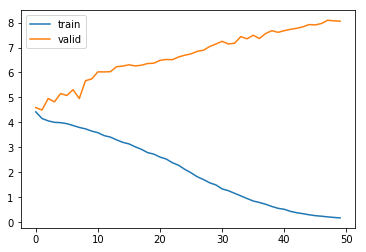

In [30]:
plt.plot(losses)
plt.legend(['train', 'valid'])

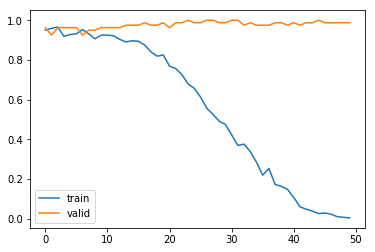

In [31]:
plt.plot(missclass)
plt.legend(['train', 'valid'])

In [33]:
print(vars(train[1]))

{'statement': ['This', 'may', 'occur', 'several', 'times', 'a', 'year', 'for', 'young', 'lobsters', ',', 'but', 'decreases', 'to', 'once', 'every', '1', '–', '2', 'years', 'for', 'larger', 'animals', '.', 'The', 'first', 'pair', 'of', '<unk>', 'is', 'armed', 'with', 'a', 'large', ',', 'pair', 'of', 'claws', '.', 'The', 'larger', 'one', 'is', 'the', '"', '<unk>', '"', ',', 'and', 'has', 'rounded', '<unk>', 'used', 'for', 'crushing', 'prey', ';', 'the', 'other', 'is', 'the', '"', 'cutter', '"', ',', 'which', 'has', 'sharp', 'inner', 'edges'], 'tag_id': '126'}
